In [321]:
import time

import numpy as np
import matplotlib.pyplot as plt
import utm
from skimage.morphology import medial_axis
from skimage.util import invert
from queue import PriorityQueue
from scipy.spatial import Voronoi
from bresenham import bresenham
from planning_utils import a_star, heuristic, create_grid, prune_path
import pkg_resources
import networkx as nx
import numpy.linalg as LA

%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 20

## Utils functions

In [322]:
def global_to_local(global_position, global_home):
    """
    Convert a global position (lon, lat, up) to a local position (north, east, down) relative to the home position.

    Returns:
        numpy array of the local position [north, east, down]
    """
    (east_home, north_home, _, _) = utm.from_latlon(global_home[1], global_home[0])
    (east, north, _, _) = utm.from_latlon(global_position[1], global_position[0])

    local_position = np.array([north - north_home, east - east_home, -global_position[2]])
    return local_position

In [323]:
def local_to_global(local_position, global_home):
    """
    Convert a local position (north, east, down) relative to the home position to a global position (lon, lat, up)

    Returns:
        numpy array of the global position [longitude, latitude, altitude]
    """
    (east_home, north_home, zone_number, zone_letter) = utm.from_latlon(global_home[1], global_home[0])
    (lat, lon) = utm.to_latlon(east_home + local_position[1], north_home + local_position[0], zone_number, zone_letter)

    lla = np.array([lon, lat, -local_position[2]])
    return lla

In [324]:
def heuristic_grid(position, goal_position):
    return np.linalg.norm(np.array(position) - np.array(goal_position))

In [325]:
def heuristic_graph(n1, n2):
    return LA.norm(np.array(n2) - np.array(n1))

In [326]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

In [327]:
# We're using collinearity here, but you could use Bresenham as well!
def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        # If the 3 points are in a line remove
        # the 2nd point.
        # The 3rd point now becomes and 2nd point
        # and the check is redone with a new third point
        # on the next iteration.
        if collinearity_check(p1, p2, p3):
            # Something subtle here but we can mutate
            # `pruned_path` freely because the length
            # of the list is check on every iteration.
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

In [328]:
def a_star_graph(graph, h, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                branch_cost = current_cost + cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))
                    
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost

In [329]:
def closest_point(graph, current_point):
    """
    Compute the closest point in the `graph`
    to the `current_point`.
    """
    closest_point = None
    dist = 100000
    for p in graph.nodes:
        d = LA.norm(np.array(p) - np.array(current_point))
        if d < dist:
            closest_point = p
            dist = d
    return closest_point

In [330]:
def create_grid_and_edges(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    along with Voronoi graph edges given obstacle data and the
    drone's altitude.
    """
    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    # Initialize an empty list for Voronoi points
    points = []
    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size-1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size-1)),
            ]
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = 1

            # add center of obstacles to points list
            points.append([north - north_min, east - east_min])

    # TODO: create a voronoi graph based on
    # location of obstacle centres
    graph = Voronoi(points)

    # TODO: check each edge from graph.ridge_vertices for collision
    edges = []
    for v in graph.ridge_vertices:
        p1 = graph.vertices[v[0]]
        p2 = graph.vertices[v[1]]
        
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        hit = False

        for c in cells:
            # First check if we're off the map
            if np.amin(c) < 0 or c[0] >= grid.shape[0] or c[1] >= grid.shape[1]:
                hit = True
                break
            # Next check if we're in collision
            if grid[c[0], c[1]] == 1:
                hit = True
                break

        # If the edge does not hit on obstacle
        # add it to the list
        if not hit:
            # array to tuple for future graph creation step)
            p1 = (p1[0], p1[1])
            p2 = (p2[0], p2[1])
            edges.append((p1, p2))

    return grid, edges

## Convert Values

In [331]:
################################## Convert NED to global ############################################
# Ned [north, east, down]
# global_position [long, lat, up]

# This information was obtainer in Udacity simulator. This is the north_offset and east_offset variables
###################### DONT CHANGE ################################
north_home = 316 
east_home = 445
down_home = 0
###################################################################

# This information was obtained in Udacity simulator. This is the global_home variable
###################### DONT CHANGE ################################
long = -122.39745
lat = 37.79248
up = 0
###################################################################

# Include here the values of NED that you want to convert
north = 600
east = 540
down = 0

ned_position = (north - north_home, east - east_home, down - down_home)
global_home = (long,lat,up)

global_position = local_to_global(ned_position, global_home)
print(global_position)

[-122.39635021   37.79503409    0.        ]


In [332]:
# Convert global to NED
# global_position [long, lat, up]
# Ned [north, east, down]


long = -122.39242841
lat =  37.79542853
up = 0

# This information was obtained in Udacity simulator. This is the global_home variable
long_home = -122.39745
lat_home = 37.79248
up_home = 0

global_position = (long,lat,up)
global_home = (long_home,lat_home,up_home)

local_position = global_to_local(global_position, global_home)
print(local_position)

[329.999964   440.00188864   0.        ]


## Configuration values

In [333]:
# Static drone altitude (meters)
drone_altitude = 5.0

# Minimum distance stay away from obstacle (meters)
safe_distance = 5.0

# Select the method [grid_search, graph_search]
method = "graph_search"

start_ne = (316,  445)
goal_ne = (600, 540)

## Compute the path from start to end

Found a path.


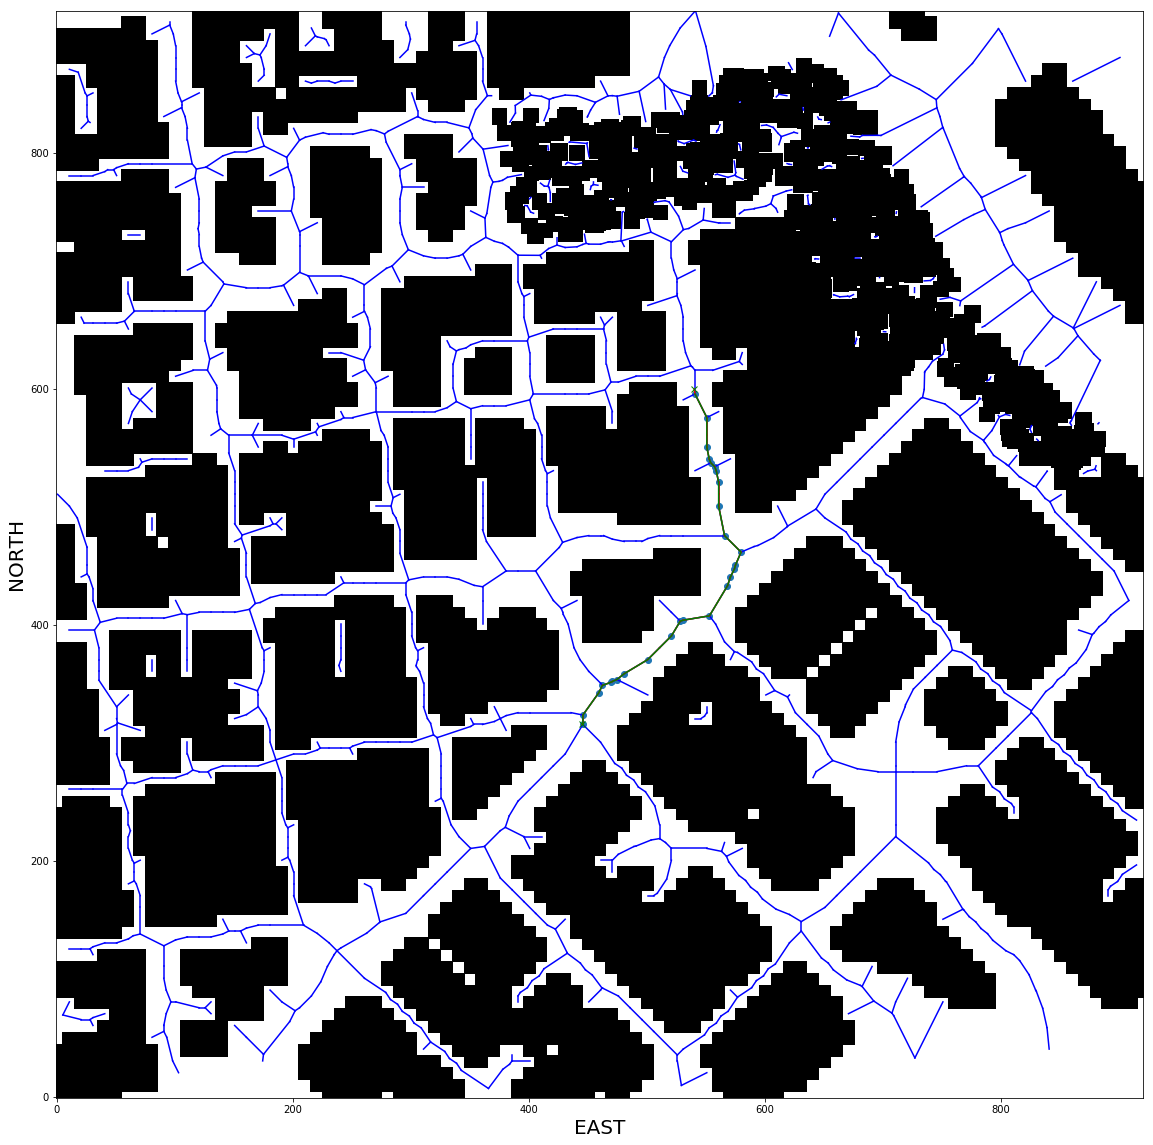

In [337]:
# Read all the values from obstacles in csv file;
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

if method == "grid_search":

    grid, north_offset, east_offset = create_grid(data, drone_altitude, safe_distance)

    path, cost = a_star(grid, heuristic_grid, start_ne, goal_ne)

    # Prune the path using 
    pruned_path = prune_path(path)

    plt.imshow(grid, cmap='Greys', origin='lower')

    plt.plot(start_ne[1], start_ne[0], 'rx')
    plt.plot(goal_ne[1], goal_ne[0], 'gx')

    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

    plt.xlabel('EAST')
    plt.ylabel('NORTH')

    plt.show()

elif method == "graph_search":
    
    grid, edges = create_grid_and_edges(data, drone_altitude, safe_distance)
    
    G = nx.Graph()
    for e in edges:
        p1 = e[0]
        p2 = e[1]
        dist = LA.norm(np.array(p2) - np.array(p1))
        G.add_edge(p1, p2, weight=dist)
        
    start_ne_g = closest_point(G, start_ne)
    goal_ne_g = closest_point(G, goal_ne)
    
    path, cost = a_star_graph(G, heuristic_graph, start_ne_g, goal_ne_g)
    
    pruned_path = prune_path(path)
        
    plt.imshow(grid, origin='lower', cmap='Greys') 

    for e in edges:
        p1 = e[0]
        p2 = e[1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
    plt.plot([start_ne[1], start_ne_g[1]], [start_ne[0], start_ne_g[0]], 'r-')
    for i in range(len(path)-1):
        p1 = path[i]
        p2 = path[i+1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
    plt.plot([goal_ne[1], goal_ne_g[1]], [goal_ne[0], goal_ne_g[0]], 'r-')
    
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

    plt.plot(start_ne[1], start_ne[0], 'gx')
    plt.plot(goal_ne[1], goal_ne[0], 'gx')

    plt.xlabel('EAST', fontsize=20)
    plt.ylabel('NORTH', fontsize=20)
    plt.show()
    
